In [2]:
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt

In [3]:
# Import the dataset and set the static variables
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

batch_size = 64
img_height = 224
img_width = 224

In [4]:
# Setting the training and validation datasets, using a split of 70% for training and 30% for validation as this is about testing the model's performance
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=420,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=420,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 2569 files for training.
Found 3670 files belonging to 5 classes.
Using 1101 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)


['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


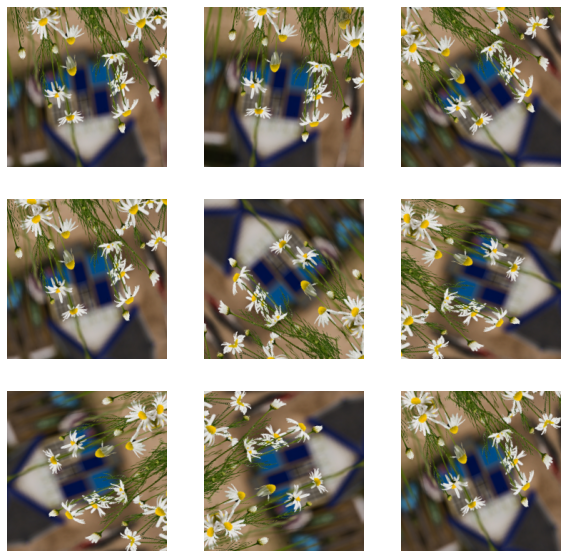

In [8]:
from tensorflow import keras

# Randomly flipping the images horizontally and vertically, and randomly rotating the images slightly
data_augmentation = keras.Sequential(
  [
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(0.2),
  ]
)
# Displaying the first 9 images from the training dataset with the augmentation applied
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
  

Now all the data has been imported, here I will train the model

I'll be mostly following this guide [here](https://keras.io/guides/transfer_learning/) and this [here](https://neptune.ai/blog/transfer-learning-guide-examples-for-images-and-text-in-keras) to help me along

In [ ]:
# Importy required libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    alpha=1.0,
    minimalistic=False,
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    classes=1000,
    pooling=None,
    dropout_rate=0.2,
    classifier_activation='softmax',
    include_preprocessing=True
)

In [ ]:
taken = list(train_ds.take(1))
image = taken[0][0]
#img = tf.keras.preprocessing.load_img(img_path, target_size=(224, 224))
#x = tf.keras.preprocessing.img_to_array(img)

#x = np.expand_dims(x, axis=0)
x = tf.keras.applications.mobilenet_v3.preprocess_input(image)
preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', tf.keras.applications.mobilenet_v3.decode_predictions(preds)[0])

35363/35363 [==============================] - 0s 1us/step
Predicted: [('n11939491', 'daisy', 0.3303987), ('n03457902', 'greenhouse', 0.019879118), ('n03991062', 'pot', 0.018454196), ('n07730033', 'cardoon', 0.014572783), ('n03930313', 'picket_fence', 0.013469157)]


Here I will rotate, zoom, crop and flip the images to increase the amount of data I have to train the model with.

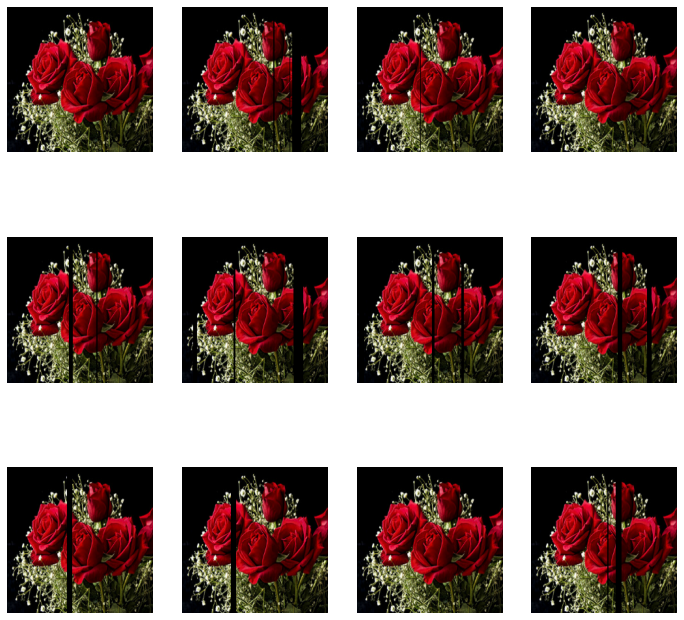

In [ ]:
def random_mask_time(img):
  MAX_OCCURENCE = 5
  MAX_LENGTH = 10
  nums = tf.random.uniform((), minval = 0, maxval = MAX_OCCURENCE, dtype=tf.int32) # number of masks
  for n in tf.range(nums):
    length = tf.random.uniform((), minval = 0, maxval = MAX_LENGTH, dtype=tf.int32) # number of columns to mask (up to 20px in time)
    pos = tf.random.uniform((), minval = 0, maxval = img.shape[1]-MAX_LENGTH, dtype=tf.int32) # position to start masking
    img = tf.concat([img[:, :, :pos,:], img[:, :, pos:(pos+length),:]*0, img[:, :, (pos+length):,:]], axis=2)
  return img

data_augmentation = keras.Sequential(
    [       
			keras.layers.RandomCrop(height=224, width=224),
			keras.layers.RandomFlip("horizontal_and_vertical"),
			keras.layers.RandomRotation(0.2, fill_mode='reflect'),
			keras.layers.Lambda(lambda x: random_mask_time(x)),
			#keras.layers.experimental.preprocessing.RandomContrast(factor=0.2),
			#keras.layers.experimental.preprocessing.RandomFlip("vertical"),
   		#keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 12))
    first_image = images[0]
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.axis("off")